** 2.5 Sarsaで迷路を攻略**

# 使用するパッケージの宣言

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 初期位置での迷路の様子

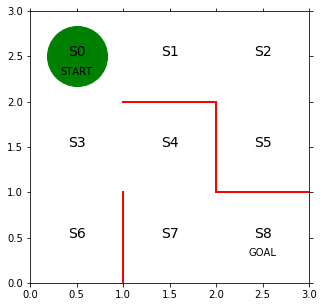

In [2]:
# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

# 初期の方策を決定するパラメータtheta_0を設定

In [3]:
# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

# 方策パラメータtheta_0をランダム方策piに変換する関数の定義

In [4]:
def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)

# 初期の行動価値関数Qを設定

- 行動価値とはあるノードであるアクションを取る、と決めた場合のその状態の「現在価値」
- 初期Qは動ける方向に乱数を割り振った行動価値関数

In [5]:
[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0
# * theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる

In [6]:
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan, nan,  1.,  1.],
       [ 1.,  1.,  1., nan],
       [nan, nan,  1.,  1.],
       [ 1., nan, nan, nan],
       [ 1., nan, nan, nan],
       [ 1.,  1., nan, nan]])

In [7]:
Q

array([[       nan, 0.57193415, 0.49886151,        nan],
       [       nan, 0.8638849 ,        nan, 0.1046475 ],
       [       nan,        nan, 0.53162051, 0.61194752],
       [0.16163784, 0.15242332, 0.0747485 ,        nan],
       [       nan,        nan, 0.16419768, 0.34576178],
       [0.62195988,        nan,        nan,        nan],
       [0.70566679,        nan,        nan,        nan],
       [0.07015311, 0.89317985,        nan,        nan]])

# ε-greedy法を実装

2_3のpolicy gradientではその時の行動方策piに基づいた確率的な時間推進していたが、$\epsilon$-greedyでは
- 確率$1-\epsilon$でQの各行の最大成分のところに飛ぶ
- 確率$\epsilon$で行動方策に基づいたランダムな時間推進をする
    - このときの確率分布はpi_0で固定されている（？）
    - つまり、サイコロを振って$\epsilon$のほうが選ばれた場合のランダム性に関しては「適当」でよい？

という構図

In [8]:
def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action

In [9]:
def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

# Sarsaによる行動価値関数Qの更新

In [10]:
def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):

    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q

# Sarsaで迷路を解く関数の定義、状態と行動の履歴および更新したQを出力

In [11]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]

## 何をやっているかの解明

In [ ]:
eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値

In [ ]:
pi = pi_0

In [ ]:
s = 0  # スタート地点

次のアクションを求める方式は$\epsilon$-greedyであればsarsaなのかQ探索なのかに依らない：

In [ ]:
a_next = get_action(s, Q, epsilon, pi)  # 初期の行動

In [ ]:
s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

In [ ]:
get_action(s, Q, epsilon, pi)

In [ ]:
a

### この辺はpolicy gradientと同じ

In [14]:
a = a_next  # 行動更新a

s_a_history[-1][1] = a
# 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

NameError: name 'a_next' is not defined

In [ ]:
s_next = get_s_next(s, a, Q, epsilon, pi)
# 次の状態を格納

In [ ]:
s_next

In [ ]:
s_a_history.append([s_next, np.nan])
# 次の状態を代入。行動はまだ分からないのでnanにしておく

# 報酬を与え,　次の行動を求めます
if s_next == 8:
    r = 1  # ゴールにたどり着いたなら報酬を与える
    a_next = np.nan
else:
    r = 0
    a_next = get_action(s_next, Q, epsilon, pi)
    # 次の行動a_nextを求めます。

In [ ]:
Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)

### 将来ペイオフの割引現在価値

In [ ]:
gamma * Q[s_next , a_next]

In [ ]:
r

(s,a)におけるクーポンはゼロなので将来価値から計算される現在価値は

In [ ]:
r + gamma * Q[s_next, a_next]

### 仮置きされている(s,a)における現在価値

In [ ]:
Q[s,a]

### 両者のミスマッチ

In [ ]:
r + gamma * Q[s_next , a_next] - Q[s,a]

In [ ]:
eta

### アップデート後の$Q[s,a]$

In [ ]:
Q[s, a] + eta * (r + gamma * Q[s_next , a_next] - Q[s,a])

# Sarsaで迷路を解く

- $\epsilon$をパスをひとつ処理する毎に0.5倍していることに注意

In [12]:
eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

while is_continue:  # is_continueがFalseになるまで繰り返す
    #print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Sarsaで迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
    #print(np.sum(np.abs(new_v - v)))  # 状態価値の変化を出力
  

    #print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")
    print('[Episode {} : L2 update norm = {:.3E} /  steps required = {}]'.format(episode, np.linalg.norm(new_v -v ) ,  len(s_a_history) - 1) , end = "  ==> ")
    v = new_v  
    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break

[Episode 1 : L2 update norm = 1.042E+00 /  steps required = 706]  ==> [Episode 2 : L2 update norm = 9.319E-02 /  steps required = 70]  ==> [Episode 3 : L2 update norm = 3.483E-02 /  steps required = 8]  ==> [Episode 4 : L2 update norm = 5.192E-02 /  steps required = 4]  ==> [Episode 5 : L2 update norm = 4.810E-02 /  steps required = 4]  ==> [Episode 6 : L2 update norm = 4.490E-02 /  steps required = 4]  ==> [Episode 7 : L2 update norm = 4.219E-02 /  steps required = 4]  ==> [Episode 8 : L2 update norm = 3.988E-02 /  steps required = 4]  ==> [Episode 9 : L2 update norm = 3.789E-02 /  steps required = 4]  ==> [Episode 10 : L2 update norm = 3.616E-02 /  steps required = 4]  ==> [Episode 11 : L2 update norm = 3.463E-02 /  steps required = 4]  ==> [Episode 12 : L2 update norm = 3.327E-02 /  steps required = 4]  ==> [Episode 13 : L2 update norm = 3.204E-02 /  steps required = 4]  ==> [Episode 14 : L2 update norm = 3.091E-02 /  steps required = 4]  ==> [Episode 15 : L2 update norm = 2.986E-02

In [13]:
Q

array([[       nan, 0.20848305, 0.72737569,        nan],
       [       nan, 0.2084962 ,        nan, 0.20772579],
       [       nan,        nan, 0.20789076, 0.20753676],
       [0.20856636, 0.8096419 , 0.21034335,        nan],
       [       nan,        nan, 0.89995135, 0.26168018],
       [0.2073761 ,        nan,        nan,        nan],
       [0.20915932,        nan,        nan,        nan],
       [0.08722032, 0.99999716,        nan,        nan]])

# 可視化

In [14]:
epsilon

3.944304526105059e-31

In [15]:
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

# sarsaに関するメモ

- 行動価値（$\sim$現在価値）Qのどこを更新するかを決めるのが$\epsilon$-greedyなるフレームワーク
 - モンテカルロ的なパス上の行動価値を順次更新していく
 - これはsarsaでもQ学習でも同じ
 
- sarsaではモンテカルロ的なパス上の次のノードにおける行動価値（パス上のさらに次の選択肢a_nextを前提とする）の割引現在価値を用いて当該ノードにおける行動価値をアップデートする
    - これに対してQ Learningではs_next(次のノードがどこか)は前提とするがa_next(次のノードでどのアクションが選択されるか)は前提としない（最大の行動価値を持つa_nextを自動的に使うため）

# sandbox

In [25]:
%%bash 
git commit -a -m "leaving sarsa"

[master af62986] leaving sarsa
 2 files changed, 1754 insertions(+), 2187 deletions(-)
 rewrite program/2_5_Sarsa.ipynb (75%)
